Import functions I generated under functionsused notebook

In [1]:
%run functionsused.ipynb

# Daily Strategy

## Daily price data
1. ETF data: 47 ETFs included with 3 different groups and 42 names. No duplicated records, no missing values. <br>

2. ETF daily price: 41 indices are selected as the ETF daily strategy universe. 
- Provides daily ETF price from 2012-01-03 to 2017-12-29.
- 79 indices in total, include @FEDON
- 7 different features ('open','close','high','low','volume','splt','dvd'). The daily strategy is based on End-of-Day price since the liquidity is bigger near mkt close, and the spread tend to be smaller.
- No duplicated records 
- Similarly to the missing values data cleaning procedure for intraday strategy, I chose 41 indices that have coverage more than 90%. 
- Similarly to the outlier detection rules applied in intraday strategy. Significant price jump (outliers) observed for a few indices on 2016-11-07. 

## Daily strategy

The daily strategy I developed is a mkt neutral PCA & ETF based mean-reverting global strategy. 

My goal is to decompose individual ETF returns into systematic and idiosyncratic components, and statistically model the idiosyncratic part as alpha. This alpha strategy based on the concept of "co-integration," which is a statistical property that exists between two or more time series that move together in the long run, even if they may diverge in the short term. The systematic factor is calibrated using PCA. <br>

**Model Development:**  
1. Using PCA to create orthogonal factors which can explain the systematic factors of global market.  
- First principle component represents the linear combination of ETF rtns that explains the most of variance and is the primary driver of global ETFs which is a proxy of overall global market. This is verified by constructing both Eigen portfolio and Mkt portfolio, expected to see two portfolios exhibit similar behaviors, and did see in my analysis.  
- I checked both the overall and rolling PCA results, the first principle component constantly explain the most variance of the correlation matrix overtime (showed a similar trend compared with using both first and second pc) and has a good economic intuition (mkt factor). To balance the need of sufficient robustness with a desire for simplicity. I used only the first principle component, but I would like to explore if using both first&second principle component would work better.  
2. Construct idiosyncratic (residual) returns. Regress individual ETF to global eigen portfolio, the residual is the ETF idiosyncratic return. 

**Trading Signals:** <br>
Daily EOD signals are estimated based on global market relative-value pricing. Co-integration residual is assumed to be the increment of stationary stochastic process which models price fluctation that is mean-reverting to overall global market (Ornstein-Uhlembeck process), which is typically associated with market over-reaction.<br>
When the deviation is large, I take a position expecting the spread to revert to its mean, thus profiting from the reversion. Vice versa (short positions). <br>
1. Individual ETF selection: to systematically capture as more accurate signals as possible, I started performing strategies with ETFs that have the fastest speed of mean-reversion.  <br>
<br>
2. Parameter estimation: 
- The paper I refer to used a rolling 60-day model to identify signals. However, to me, rolling parameters won't provide consistent/comparable residual signals, as the ETF weights are dynamic given that they are generated by performing PCA on different periods of empirical data. <br>
- I prefer to use quarterly (follow earnings cycle) PCA first principle component to construct factors. Estimate residual and develop trading signals on top of it.  (I might want to explore semi-annual signals going forward, if the signals are too volatile going forward, or eigen factor loadings are too jumpy.) <br>
3. Long/short signals: based on the empirical standardized co-integration residual distribution, I set entry signal as any residuals that deviates 1.25 standard deviation from equilibrium (positive for short while negative for long) and closing signals 0.1 in absolute value, when individual ETF is near equilibrium.



**Backtesting results:** <br>
Based on the trading signals as I described above, the market neutral book I developed has its pros and cons. I would recommend performing customize analysis based on different goals of the strategy. <br>

Pros: 
- The overall annualized sharpe ratio for each selected ETF strategy varies from 0.96 to 2.78, which is profitable.  
- For each individual ETF strategy, the most of the single trades are making money. <br>

Cons: 
- For each individual ETF strategy, the frequent of each trade is pretty low. ~10/year. As to maintain a high accuracy, I define the excursions as very large deviations from equilibrium which constrains the trading signals tight. 
- I'm performing backtesting for each ETF seperately, as I think to construct an optimal portfolio across ETFs need specific goals, like certain risk tolerance, size and liquidity of the book, etc.. 

**Optimization** <br>
- The current analysis is based on quarterlty empirical analysis. But we can further define normal and stress periods (i.e., 2008 & 2011 & 2020) and customize empirical analysis to calibrate PCA principle components and trading signal magnitudes under different scenarios. 
- Currently the model parameters calibrated quarterly, might need to rebalance portfolio correspondingly.  
- Given that PCA principal components are orthoganol, in theory, the more factors, the more information are provided, it could bring better prediction effectiveness. I would explore different numbers of PC. 
- Similarly to the intraday strategy, transaction cost & market impacts matter in real trading, which worth further analysis. 
- There are split and dividend information which worth further exploration, as they could bring impacts to ETF price change.

**Note:** Reference materials: <br>
Statistical Arbitrage in the U.S. Equity Market   
https://www.quantconnect.com/learning/articles/investment-strategy-library/mean-reversion-statistical-arbitrage-strategy-in-stocks 

### Read Data

**ETF data**

In [2]:
ETF = pd.read_excel('../data/univ_pca.xlsx')
display(ETF.head(2))

,ticker,group,name
0,EWJ US Equity,country,ISHARES MSCI JPN
1,MCHI US Equity,country,ISHARES MSCI CHI


**ETF price data**

In [3]:
dailyprice = pd.read_pickle('../data/daily.pk')
dailyprice.columns = dailyprice.columns.rename([None,'uid'])

pricecol=['open','close','high','low','volume','splt','dvd']
dailyprice = dailyprice[pricecol]
display(dailyprice.tail(2))

open                                                              \
uid        @FEDON  AAXJ  CNYA   ECH  EDEN  EEMA  EFNL  EIDO  EIRL   EIS  EMXC   
2017-12-28    nan 76.15 31.83 52.00 67.24 73.72 39.44 28.36 47.92 51.46 53.64   
2017-12-29    nan 76.53 32.15 52.43 67.40 74.19 39.42 28.48 48.19 51.58 53.94   

                                                                              \
uid         ENOR  ENZL  EPHE  EPOL   EPP   EPU  ERUS   EWA   EWC   EWD   EWG   
2017-12-28 25.77 47.67 38.72 27.17 47.80 40.66 33.30 23.24 29.50 34.10 33.28   
2017-12-29 25.78 47.88 38.91 27.18 47.97 40.87 33.61 23.28 29.78 34.02 33.14   

                                                                              \
uid          EWH   EWI   EWJ   EWK   EWL   EWM   EWN   EWO   EWP   EWQ   EWS   
2017-12-28 25.37 30.71 59.98 20.97 35.57 32.72 31.77 24.69 32.87 31.36 25.91   
2017-12-29 25.47 30.58 60.02 20.98 35.61 33.12 31.77 24.75 32.83 31.37 25.97   

                                                                               \
uid          EWT   EWU   EWW   EWY   EWZ   EZA   EZU    GLD   GXG  IEFA  IEMG   
2017-12-28 36.03 35.61 48.50 74.75 40.35 69.43 43.64 122.82 10.15 66.20 56.76   
2017-12-29 36.35 35.99 48.70 75.29 40.45 70.32 43.52 123.70 10.08 66.32 57.06   

                                                                            \
uid         IEUR  INDA    IVV    IWM   KSA  MCHI   QAT    QQQ    SPY  SQQQ   
2017-12-28 50.25 35.81 269.80 153.24 25.61 66.78 16.08 157.05 267.89 21.00   
2017-12-29 50.41 36.14 270.50 154.15 26.24 66.74 16.04 156.90 268.53 21.07   

                                                                              \
uid           SSO   SVXY   THD    TLT   TQQQ   TUR   UAE   UPRO  URTH    VTI   
2017-12-28 110.12 129.05 91.92 126.53 142.26 42.90 16.61 141.54 88.38 137.79   
2017-12-29 110.65 131.20 92.65 126.50 141.92 43.33 16.92 142.60 88.53 138.08   

                                                                          \
uid           VTV    VUG VXX VXZ   XLB XLC   XLE   XLF   XLI   XLK   XLP   
2017-12-28 106.60 141.38 nan nan 60.44 nan 72.35 28.07 75.87 64.37 57.07   
2017-12-29 106.93 141.56 nan nan 60.87 nan 72.66 28.20 75.97 64.33 56.90   

                                    close                                      \
uid         XLRE   XLU   XLV   XLY @FEDON  AAXJ  CNYA   ECH  EDEN  EEMA  EFNL   
2017-12-28 32.75 52.46 83.22 99.35   1.41 76.00 31.83 52.30 67.05 73.33 39.40   
2017-12-29 32.96 52.81 83.33 99.30   1.31 76.28 32.03 52.16 67.59 73.75 39.42   

                                                                              \
uid         EIDO  EIRL   EIS  EMXC  ENOR  ENZL  EPHE  EPOL   EPP   EPU  ERUS   
2017-12-28 28.36 48.16 51.51 53.55 25.69 47.55 38.67 27.19 47.76 40.85 33.47   
2017-12-29 28.43 47.99 51.29 53.93 25.80 47.47 38.82 27.09 47.80 40.98 33.52   

                                                                              \
uid          EWA   EWC   EWD   EWG   EWH   EWI   EWJ   EWK   EWL   EWM   EWN   
2017-12-28 23.19 29.62 33.98 33.15 25.29 30.68 59.82 20.97 35.53 32.77 31.72   
2017-12-29 23.17 29.64 33.90 33.02 25.42 30.44 59.93 21.02 35.58 32.97 31.73   

                                                                              \
uid          EWO   EWP   EWQ   EWS   EWT   EWU   EWW   EWY   EWZ   EZA   EZU   
2017-12-28 24.69 32.82 31.27 25.91 35.97 35.61 48.57 74.79 40.31 69.07 43.48   
2017-12-29 24.64 32.77 31.22 25.93 36.21 35.82 49.29 74.93 40.45 69.99 43.38   

                                                                           \
uid           GLD   GXG  IEFA  IEMG  IEUR  INDA    IVV    IWM   KSA  MCHI   
2017-12-28 122.85 10.00 66.00 56.62 50.17 35.68 269.79 153.73 26.24 66.40   
2017-12-29 123.65 10.02 66.09 56.90 50.17 36.07 268.85 152.46 26.18 66.54   

                                                                              \
uid          QAT    QQQ    SPY  SQQQ    SSO   SVXY   THD    TLT   TQQQ   TUR   
2017-12-28 16.05 156.73 2

### Data Exploration

**ETF Data**

In [4]:
ETF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ticker  47 non-null     object
 1   group   47 non-null     object
 2   name    47 non-null     object
dtypes: object(3)
memory usage: 1.2+ KB


In [5]:
##### No duplicated rows observed - duplicated group & name observed 
display('Number of days included: '+str(ETF.shape[0]))
ETF = ETF.drop_duplicates()
display('Number of days included after drop duplicates: '+str(ETF.shape[0]))
display(ETF.nunique())

'Number of days included: 47'

'Number of days included after drop duplicates: 47'

ticker    47
group      3
name      42
dtype: int64

In [6]:
##### Find duplicated name 
ETF[ETF.duplicated(['name'],keep=False)]

,ticker,group,name
1,MCHI US Equity,country,ISHARES MSCI CHI
4,EWY US Equity,country,ISHARES MSCI SOU
5,INDA US Equity,country,ISHARES MSCI IND
9,EWA US Equity,country,ISHARES MSCI AUS
16,CNYA US Equity,country,ISHARES MSCI CHI
21,ECH US Equity,country,ISHARES MSCI CHI
23,EZA US Equity,country,ISHARES MSCI SOU
24,EIDO US Equity,country,ISHARES MSCI IND
34,EWO US Equity,country,ISHARES MSCI AUS


In [7]:
##### Specify the 47 ETFs 
ETF_list = ETF['ticker'].str.split(' ').str.get(0)
#ETF_list[:3]
display('Number of indices that are included: '+str(len(ETF_list)))


'Number of indices that are included: 47'

**ETF price data**

In [8]:
dailyprice.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2012-01-03 to 2017-12-29
Columns: 553 entries, ('open', '@FEDON') to ('dvd', 'XLY')
dtypes: float64(553)
memory usage: 6.4 MB


In [9]:
##### check duplicates - no duplicates detected 
display('Number of days included: '+str(dailyprice.shape[0]))
dailyprice = dailyprice.drop_duplicates()
display('Number of days included after drop duplicates: '+str(dailyprice.shape[0]))


'Number of days included: 1509'

'Number of days included after drop duplicates: 1509'

In [10]:
##### compared with @FEDON data in intraday strategy, the data quality is better
dailyprice.loc[:, (slice(None),'@FEDON')].describe()

,open,close,high,low,volume,splt,dvd
uid,@FEDON,@FEDON,@FEDON,@FEDON,@FEDON,@FEDON,@FEDON
count,"1,187.00","1,495.00","1,190.00","1,187.00",306.00,"1,509.00","1,509.00"
mean,0.16,0.31,0.26,0.12,0.00,1.00,0.00
std,0.10,0.34,0.10,0.11,0.00,0.00,0.00
min,0.01,0.00,0.00,0.00,0.00,1.00,0.00
25%,0.09,0.09,0.23,0.05,0.00,1.00,0.00
50%,0.13,0.14,0.25,0.08,0.00,1.00,0.00
75%,0.17,0.40,0.28,0.12,0.00,1.00,0.00
max,0.42,1.41,0.69,0.90,0.00,1.00,0.00


**Select ETF that are listed in univ_pca file**

In [11]:
dailyprice = dailyprice.loc[:,(slice(None),ETF_list)]


**I chose to use end-of-day price for my strategy as the liquidity is good near mkt close and the spread tend to be smaller.** <br>
I excluded 6 indices as their missing values percentage is bigger than 10%. 41 indices are chosen for further analysis.

**Missing Values Treatment**

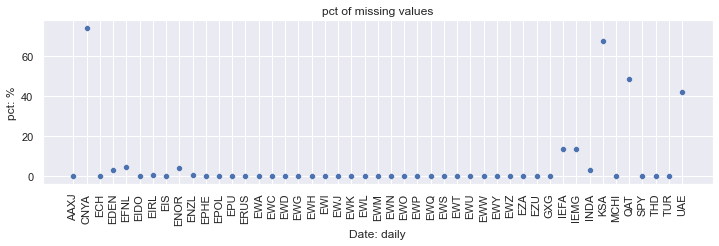

In [12]:
closeprice = dailyprice['close']

##### check missing value percentage
closemissing = (100*closeprice.isnull().sum()/len(closeprice)).to_frame().reset_index().rename(columns={0:'pct'})
visualization(closemissing,x='uid',y='pct',title='pct of missing values',
              xlabel='Date: daily',ylabel='pct: %',rotation_angel=90, scatter=True)

**Selected 41 indices after performing missing value analysis**

'Number of indices that have historical data coverage over 90%: 41'

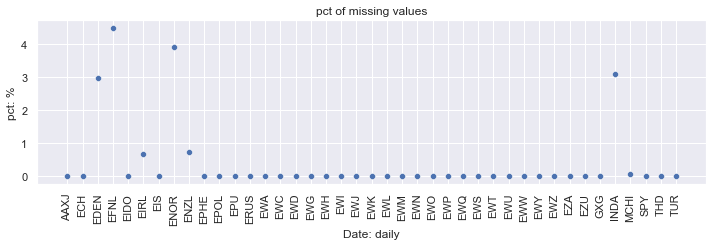

'1509 days are selected. With 1 ETFs.'

In [13]:
ETF_filtered = list(closemissing.loc[closemissing.pct <10].uid)
display('Number of indices that have historical data coverage over 90%: '+str(len(ETF_filtered)))

visualization(closemissing.loc[closemissing.pct <10],x='uid',y='pct',title='pct of missing values',
              xlabel='Date: daily',ylabel='pct: %',rotation_angel=90, scatter=True)

closeprice = closeprice[ETF_filtered]
display(str(closeprice.shape[0])+' days are selected. With '+str(int(closeprice.shape[1]/closeprice.columns.get_level_values(0).nunique())) +' ETFs.')


In [14]:
##### calculate EOD return 
closertn = closeprice.pct_change()
# display(closertn.head(2)) 
##### drop 2% missing rtn 
display('Number of days included: '+str(closertn.shape[0]))
closertn = closertn.dropna()
display('Number of days included after drop missing values: '+str(closertn.shape[0]))


'Number of days included: 1509'

'Number of days included after drop missing values: 1486'

### Data outlier detection
**Check whether there are abnormal return jump/drop** <br>
After observed abnormal jump/drop, need to verify whether the return move is valid, I verified using google ETF return. <br>
- Observed abnormal jump for a few indices on 2016-11-07. Deleted the date after double-check google data.
- My intuitive expectation is that absolute return won't bigger than 100%. 

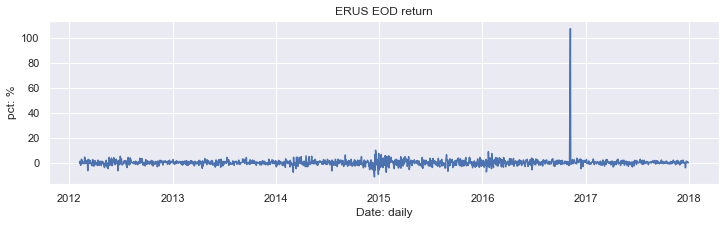

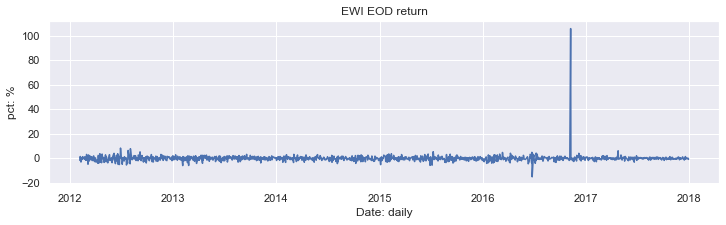

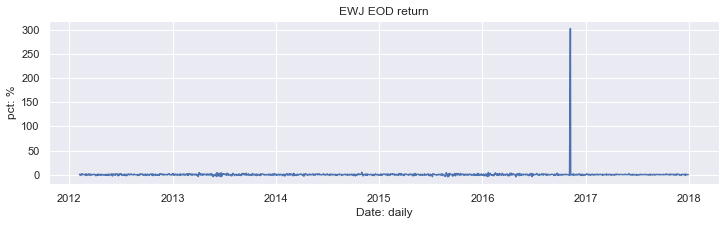

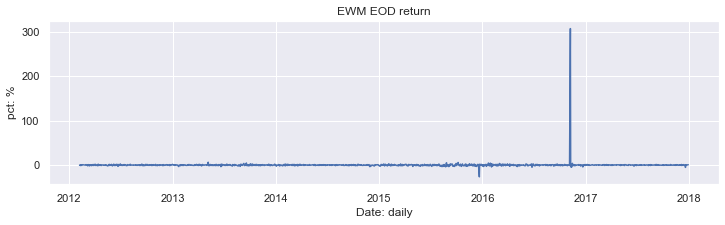

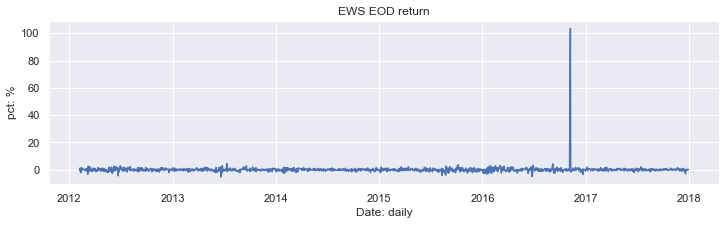

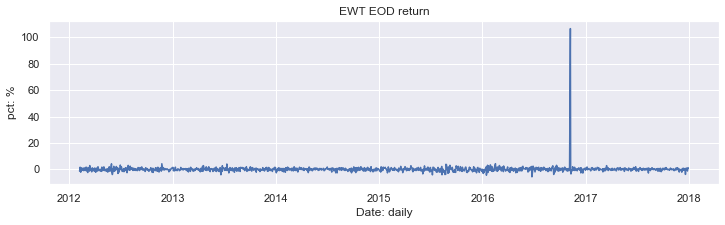

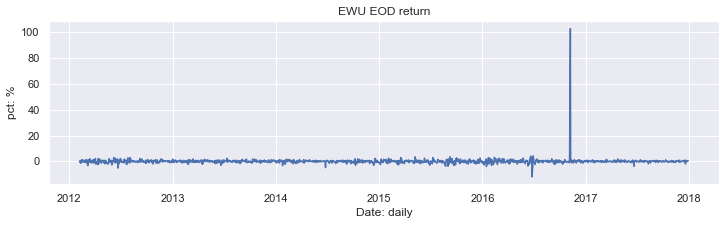

In [15]:
##### verify the price change in percentage unit
EOD_viz = 100*closertn
EOD_viz = EOD_viz.reset_index().rename(columns={'index':'date'})

for index in ETF_filtered:
    if EOD_viz[EOD_viz[index]>100].any().any():
        visualization(df=EOD_viz,x='date',y=index,title=index+' EOD return',
                  xlabel='Date: daily',ylabel='pct: %',rotation_angel=0)

In [16]:
##### select ETFs that have return bigger than 100%.
closertn.columns[closertn.gt(1).any()]

Index(['ERUS', 'EWI', 'EWJ', 'EWM', 'EWS', 'EWT', 'EWU'], dtype='object', name='uid')

After excluded the one date, the ETF returns look reasonable to me. 

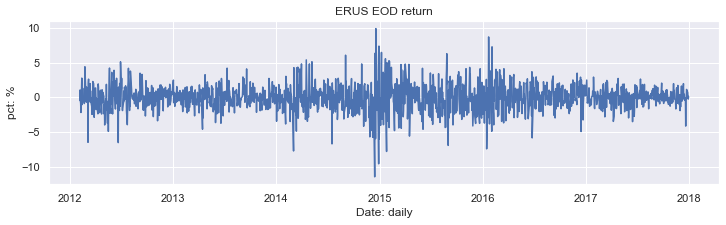

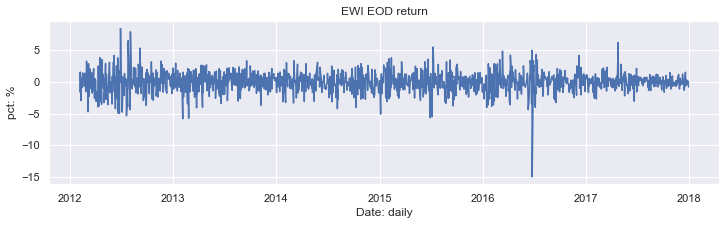

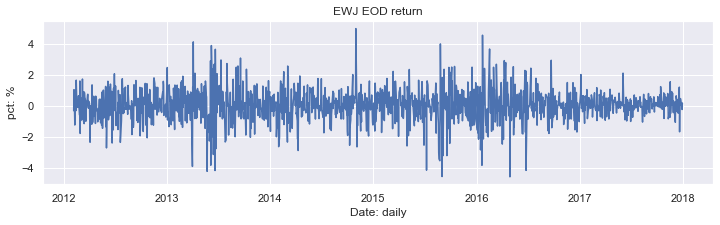

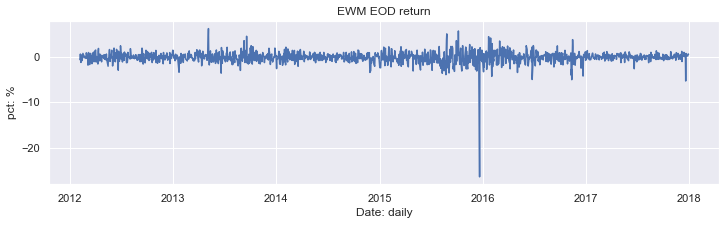

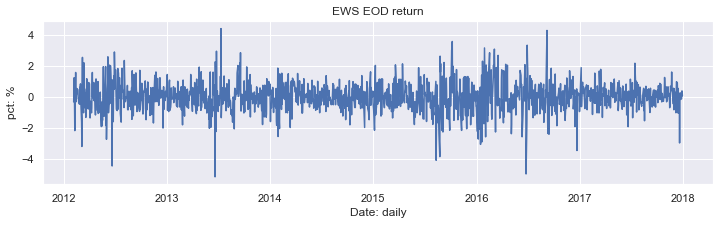

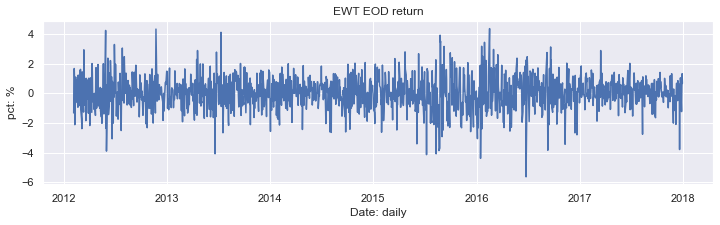

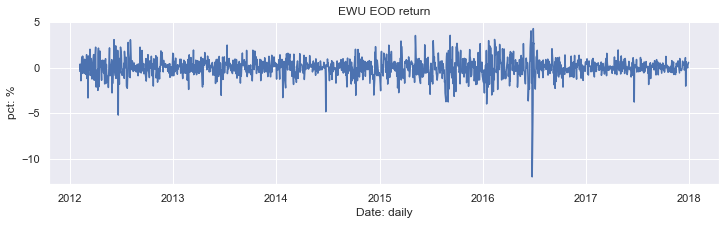

In [17]:
EOD_viz = EOD_viz.loc[EOD_viz.date != '2016-11-07']
for index in closertn.columns[closertn.gt(1).any()]:
    visualization(df=EOD_viz,x='date',y=index,title=index+' EOD return',
              xlabel='Date: daily',ylabel='pct: %',rotation_angel=0)

### Extracting risk factors using PCA

Eigen portfolio & mkt portfolio: First principle component represents the linear combination of ETF rtns that explains the most of variance and the primary driver of global ETFs is the overall market factor. 

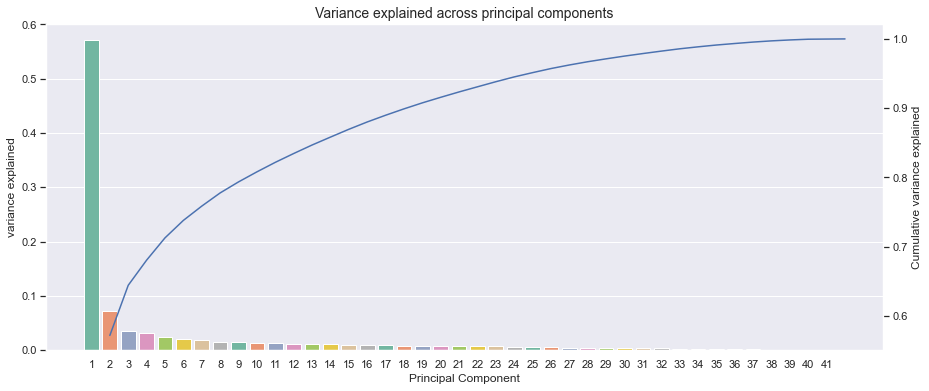

In [18]:
closertn = closertn.loc[closertn.index != '2016-11-07']
ETF_rtn = closertn.copy()
##### get pct variance explained and eigenvector from PCA
df_explained_variance, eigenvector = get_pca_variance_explained(df=closertn, index_list=ETF_filtered)

viz_pca_variance(df=df_explained_variance)

**Eigen Vector**

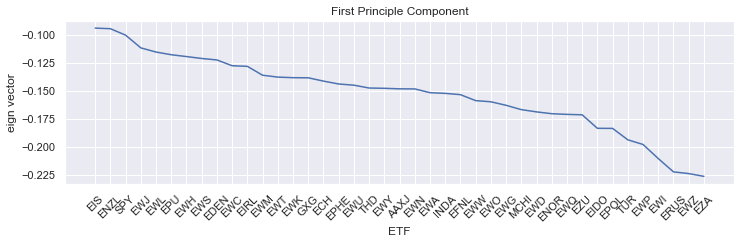

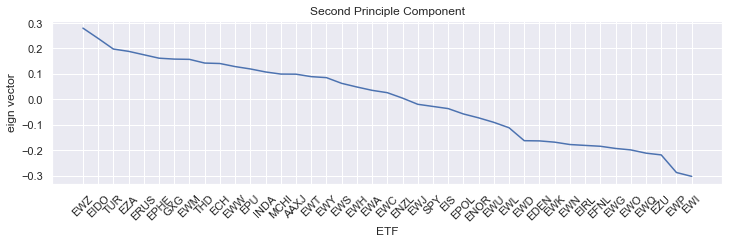

In [19]:
##### Principle Componnet 
eign_viz = eigenvector.T.reset_index()

##### First Principle Component 
visualization(eign_viz.sort_values(by='PrincipleComponent1',ascending=False),x='index',y='PrincipleComponent1',title='First Principle Component',
              xlabel='ETF',ylabel='eign vector',rotation_angel=45)
##### Second Principle Componen
visualization(eign_viz.sort_values(by='PrincipleComponent2',ascending=False),x='index',y='PrincipleComponent2',title='Second Principle Component',
              xlabel='ETF',ylabel='eign vector',rotation_angel=45)

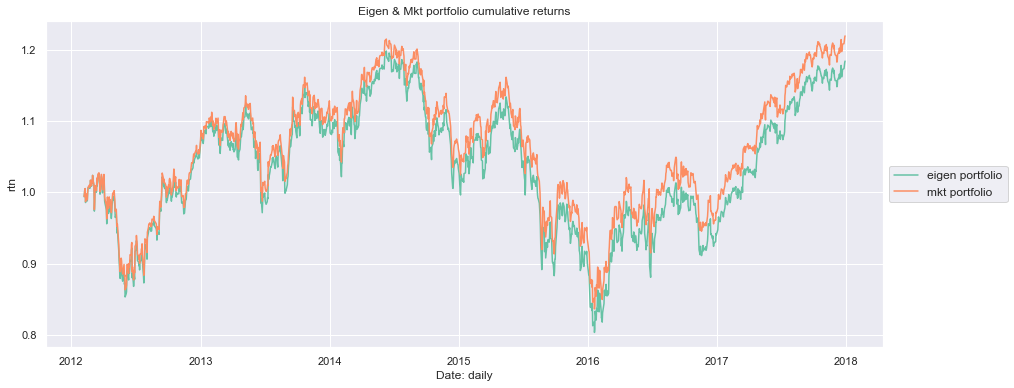

In [20]:
pc1weight = eigenvector.loc['PrincipleComponent1',:]/sum(eigenvector.loc['PrincipleComponent1',:])

closertn['eign_port'] = closertn[ETF_filtered].mul(pc1weight).sum(axis=1)
closertn['mkt_port'] = closertn[ETF_filtered].mean(axis=1)
closertn['eigen portfolio'] = (1+closertn['eign_port']).cumprod()
closertn['mkt portfolio']= (1+closertn['mkt_port']).cumprod()

portfoliortn = closertn.reset_index().rename(columns={'index':'date'})[['date','eigen portfolio','mkt portfolio']]
portfoliortn = portfoliortn.melt(id_vars='date',value_vars=['eigen portfolio','mkt portfolio'])

visualization(portfoliortn,x='date',y='value',hue='uid',title='Eigen & Mkt portfolio cumulative returns',
              xlabel='Date: daily',ylabel='rtn',rotation_angel=0, figsize=(15,6))

**Rolling PCA** <br>



**Variance explained by First & Second principle component**

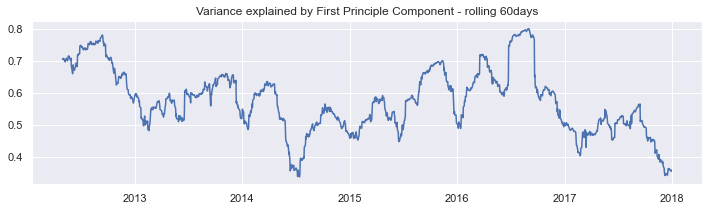

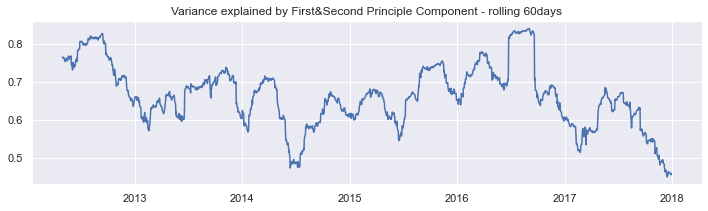

In [21]:
Mkt_pca = get_rolling_PCA(df=ETF_rtn, index_list=ETF_filtered, window=60)

Mkt_pca = Mkt_pca.reset_index().rename(columns={'index':'date'})

visualization(df=Mkt_pca,x='date',y='variance_explained',
              title='Variance explained by First Principle Component - rolling 60days',rotation_angel=0)

visualization(df=Mkt_pca,x='date',y='variance_explained_2',
              title='Variance explained by First&Second Principle Component - rolling 60days', rotation_angel=0)



**Estimate quarterly pca parameters**

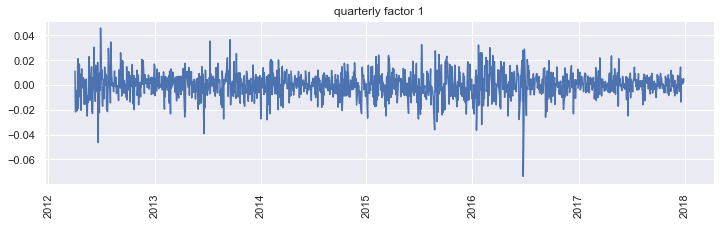

In [22]:
Mkt_pca.loc[:,'quarter'] = Mkt_pca['date'].dt.to_period('Q')
PCA_weight = Mkt_pca.drop_duplicates(subset=['quarter'], keep='first').reset_index(drop=True)

ETF_rtn = ETF_rtn.reset_index().rename(columns={'index':'date'})
ETF_rtn.loc[:,'quarter'] = ETF_rtn['date'].dt.to_period('Q')

ETF_rtn.loc[:,'factor1'] = [np.nan]*len(ETF_rtn)

for date in ETF_rtn.date:
    
    quarter = ETF_rtn.loc[ETF_rtn.date == date,'quarter'].values[0]
    if len(PCA_weight.loc[PCA_weight.quarter == quarter,ETF_filtered].values)>0:
        w = PCA_weight.loc[PCA_weight.quarter == quarter,ETF_filtered].values[0]
        w = w/sum(w)

        ETF_rtn.loc[ETF_rtn.date == date,'factor1'] = ETF_rtn.loc[ETF_rtn.date == date,ETF_filtered].mul(w).sum(axis=1).values[0]

visualization(df=ETF_rtn,x='date',y='factor1',
              title='quarterly factor 1', rotation_angel=90)



**Estimate trading signal s-score** <br>
s-score is a standardized co-integration residual based on OU process. <br>
Based on the empirical analysis, the entry signal is any residual that deviates 1.25 standard deviation from equilibrium (positive for short while negative for long) ~10% of time annualy, and closing signals 0.1 in absolute value, when individual ETF is near equilibrium. But we can also choose closing trades when s-score is bigger, depends on our goal of the holding period. 

In [23]:
ETF_sscore = ETF_rtn.dropna()
ETF_sscore = get_rolling_sscore(df=ETF_sscore,index_list=ETF_filtered)

In [24]:
##### distribution of trading signals across ETFs
display('Quantile distribution of empirical standardized residuals')
display(ETF_sscore.describe([0.05,0.1,0.15,0.2,0.45, 0.5,0.55,0.8, 0.85,0.9,0.95]))
display('Average quantiles across ETFs')
display(ETF_sscore.describe([0.05,0.1,0.15,0.2,0.45, 0.5,0.55,0.8, 0.85,0.9,0.95]).mean(axis=1).to_frame().T)

'Quantile distribution of empirical standardized residuals'

uid,AAXJ,ECH,EDEN,EFNL,EIDO,EIRL,EIS,ENOR,ENZL,EPHE,EPOL,EPU,ERUS,EWA,EWC,EWD,EWG,EWH,EWI,EWJ,EWK,EWL,EWM,EWN,EWO,EWP,EWQ,EWS,EWT,EWU,EWW,EWY,EWZ,EZA,EZU,GXG,INDA,MCHI,SPY,THD,TUR,factor1
count,"1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00","1,446.00"
mean,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.01
min,-3.15,-4.12,-4.77,-5.90,-5.16,-4.48,-4.83,-4.35,-4.04,-3.32,-4.59,-3.76,-3.98,-5.33,-3.08,-5.06,-3.29,-4.05,-3.36,-4.25,-3.71,-4.40,-7.55,-3.42,-3.84,-4.73,-3.63,-4.15,-3.79,-6.02,-4.05,-3.93,-6.26,-3.99,-3.34,-4.59,-3.92,-3.10,-3.49,-4.74,-4.51,-0.07
5%,-1.58,-1.61,-1.62,-1.62,-1.62,-1.62,-1.66,-1.60,-1.65,-1.65,-1.55,-1.58,-1.55,-1.65,-1.68,-1.63,-1.61,-1.63,-1.65,-1.66,-1.65,-1.68,-1.56,-1.66,-1.61,-1.58,-1.59,-1.62,-1.59,-1.63,-1.60,-1.57,-1.57,-1.61,-1.65,-1.69,-1.65,-1.60,-1.61,-1.64,-1.67,-0.02
10%,-1.23,-1.24,-1.23,-1.19,-1.22,-1.22,-1.20,-1.24,-1.30,-1.23,-1.22,-1.19,-1.23,-1.21,-1.31,-1.24,-1.25,-1.20,-1.31,-1.25,-1.24,-1.23,-1.12,-1.30,-1.26,-1.20,-1.25,-1.21,-1.24,-1.22,-1.18,-1.24,-1.22,-1.25,-1.24,-1.24,-1.20,-1.27,-1.27,-1.25,-1.19,-0.01
15%,-1.00,-0.97,-0.98,-0.94,-0.99,-1.01,-0.96,-0.99,-1.02,-0.99,-1.01,-0.95,-0.99,-0.94,-1.05,-1.02,-1.00,-0.96,-1.03,-0.99,-1.04,-0.99,-0.87,-1.05,-1.04,-0.98,-1.01,-0.97,-1.00,-0.97,-0.96,-0.97,-0.99,-0.98,-1.00,-0.96,-0.94,-1.00,-1.03,-0.93,-0.94,-0.01
20%,-0.82,-0.76,-0.76,-0.78,-0.76,-0.83,-0.76,-0.81,-0.80,-0.78,-0.85,-0.78,-0.83,-0.75,-0.83,-0.83,-0.81,-0.77,-0.81,-0.77,-0.81,-0.77,-0.72,-0.84,-0.84,-0.80,-0.80,-0.76,-0.80,-0.77,-0.78,-0.79,-0.81,-0.78,-0.80,-0.77,-0.76,-0.81,-0.81,-0.74,-0.71,-0.01
45%,-0.15,-0.11,-0.09,-0.09,-0.11,-0.13,-0.09,-0.15,-0.08,-0.13,-0.10,-0.12,-0.14,-0.12,-0.10,-0.09,-0.12,-0.13,-0.11,-0.10,-0.08,-0.10,-0.10,-0.09,-0.11,-0.12,-0.10,-0.11,-0.12,-0.10,-0.13,-0.13,-0.13,-0.11,-0.09,-0.11,-0.11,-0.14,-0.08,-0.09,-0.08,-0.00
50%,-0.01,-0.01,0.01,0.02,0.01,0.01,0.01,-0.02,0.02,-0.03,0.00,-0.00,-0.00,0.01,0.01,0.03,-0.02,-0.03,0.01,0.01,0.02,0.02,0.00,0.02,0.01,-0.02,0.01,0.00,-0.01,0.02,-0.03,-0.01,0.01,0.00,0.01,-0.01,-0.01,-0.03,0.03,0.02,0.02,0.00


'Average quantiles across ETFs'

,count,mean,std,min,5%,10%,15%,20%,45%,50%,55%,80%,85%,90%,95%,max
0,"1,446.00",0.00,0.98,-4.19,-1.58,-1.20,-0.96,-0.77,-0.11,0.00,0.11,0.77,0.95,1.20,1.59,4.08


**Viz SPY s-score as an example**

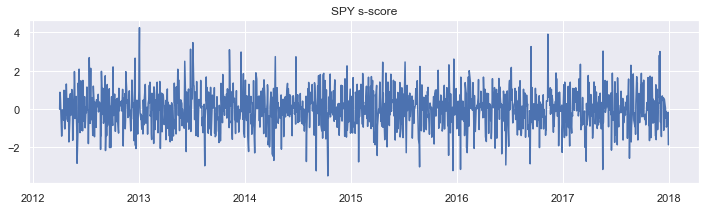

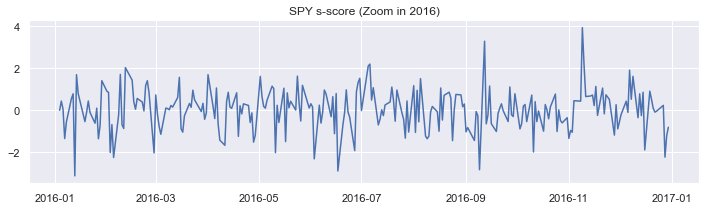

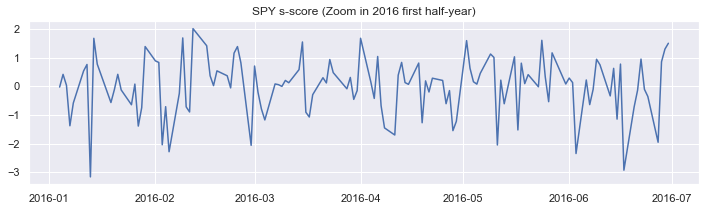

In [25]:

visualization(df=ETF_sscore,x='date',y='SPY',
              title='SPY s-score', rotation_angel=0)
visualization(df=ETF_sscore.loc[(ETF_sscore.date>'2016-01-01')&(ETF_sscore.date<'2017-01-01')],x='date',y='SPY',
              title='SPY s-score (Zoom in 2016)', rotation_angel=0)
visualization(df=ETF_sscore.loc[(ETF_sscore.date>'2016-01-01')&(ETF_sscore.date<'2016-07-01')],x='date',y='SPY',
              title='SPY s-score (Zoom in 2016 first half-year)', rotation_angel=0)


In [26]:
##### Save return for each trade for each ETF 
Strategy_rtn = {}

for index in ETF_filtered:
    index_rtn = index_tradingrtn(index=index, sscore=ETF_sscore, rtn=ETF_rtn, )
    Strategy_rtn[index] = index_rtn

In [27]:
##### Calibrate annualized Sharpe for each ETF strategy 
annualSharpe=pd.DataFrame(columns=['annualSharpe','trades'])
for index in Strategy_rtn.keys():
    annualSharpe.loc[index,:]=[annualized_sharpe(Strategy_rtn[index]),len(Strategy_rtn[index])]
annualSharpe = annualSharpe.sort_values(by='annualSharpe',ascending=False)

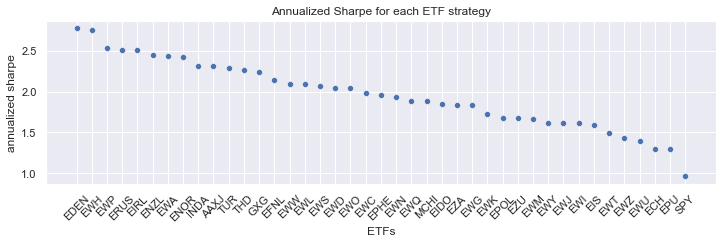

In [28]:
visualization(annualSharpe.reset_index(),x='index',y='annualSharpe',title='Annualized Sharpe for each ETF strategy',
              xlabel='ETFs',ylabel='annualized sharpe',rotation_angel=45, scatter=True)

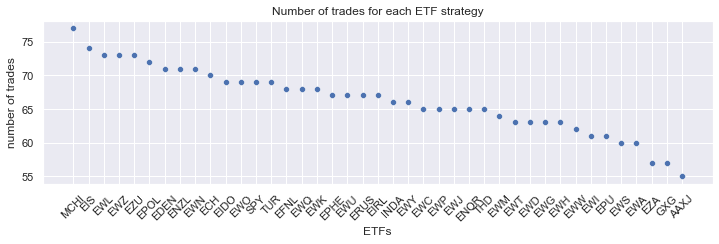

In [29]:
visualization(annualSharpe.reset_index().sort_values(by='trades', ascending=False),x='index',y='trades',title='Number of trades for each ETF strategy',
              xlabel='ETFs',ylabel='number of trades',rotation_angel=45, scatter=True)

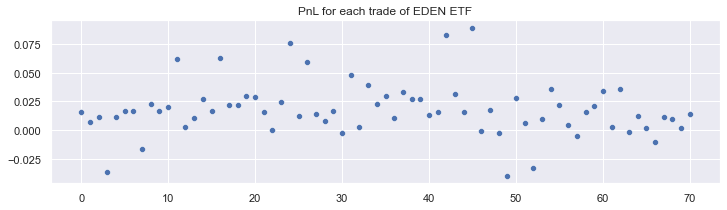

In [30]:
fig = plt.figure(figsize=(12,3))
sns.scatterplot(y = Strategy_rtn['EDEN'], x=range(len(Strategy_rtn['EDEN'])))
plt.title('PnL for each trade of EDEN ETF')
plt.show()

**Viz for all available data for SPY as an example** <br>
For future analysis

In [31]:
SPY = pd.DataFrame(data=dailyprice.loc[:, (slice(None),'SPY')].values, columns=pricecol)
SPY.loc[:,'date'] = dailyprice.index
SPY = SPY[['date']+pricecol]
SPY.head(2)

,date,open,close,high,low,volume,splt,dvd
0,2012-01-03,127.76,127.50,128.38,127.43,"193,697,825.00",1.00,0.00
1,2012-01-04,127.20,127.70,127.81,126.71,"127,186,456.00",1.00,0.00


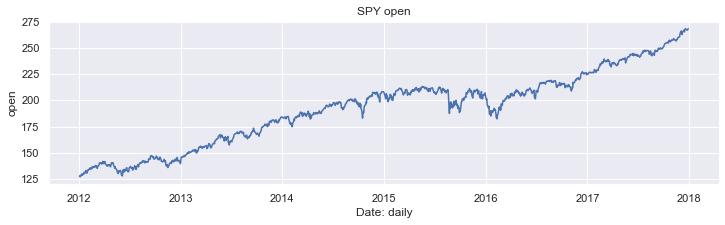

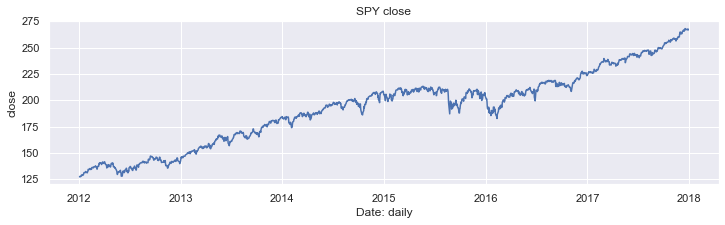

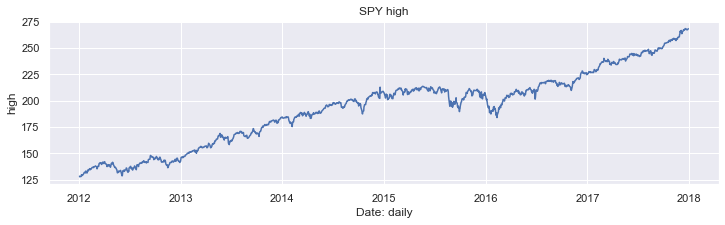

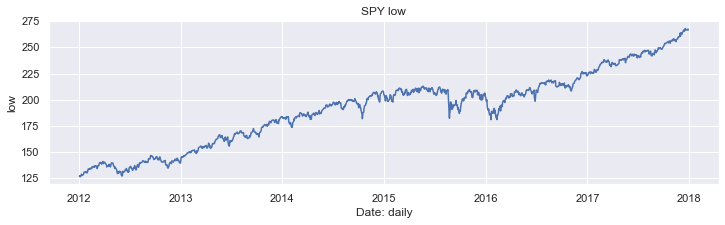

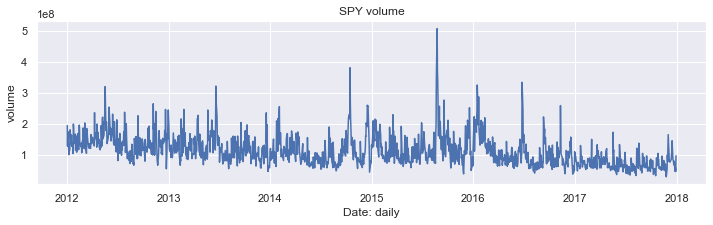

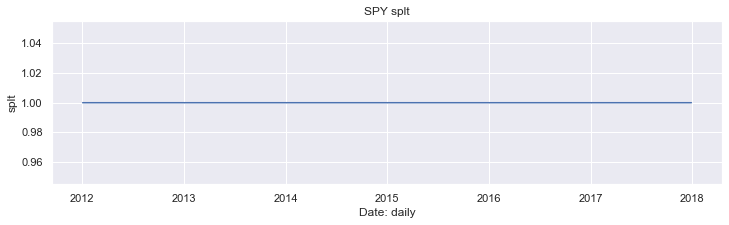

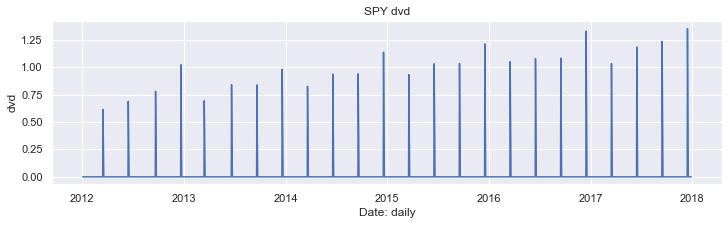

In [32]:
for time in pricecol:
    visualization(SPY,x="date",y=time,title='SPY '+time,xlabel='Date: daily',ylabel=time,rotation_angel=0)